In [100]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window
from scipy.stats import linregress
from scipy import stats
from scipy.interpolate import interp1d

Goal is to create a feature set consisting of

1. Fractal dimension
2. VMS
3. LI

OUTPUT: A csv file of the features with 0 for normal and 1 for pathological


In [3]:
data_path = "../data/open_vag/normal/novag1"
normal_dir = "../data/open_vag/normal/"
pathology_dir = "../data/open_vag/pathology/"

normal_vag_subjects = [] # 51
pathology_vag_subjects = [] # 38

# read all the files in the normal folder
novag_base_f = "novag"
ab_base_f  = "abvag"

# read normal files
for i, filename in enumerate(os.listdir(normal_dir)):
    file_path = os.path.join(normal_dir, f"{novag_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        vags = [float(x) for x in file.read().split()]
        normal_vag_subjects.append(vags)
        
# read pathology files
for i, filename in enumerate(os.listdir(pathology_dir)):
    file_path = os.path.join(pathology_dir, f"{ab_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        p_vags = [float(x) for x in file.read().split()]
        pathology_vag_subjects.append(p_vags)

print(f"{len(normal_vag_subjects)} normal subjects")
print(f"{len(pathology_vag_subjects)} pathology subjects")

51 normal subjects
38 pathology subjects


First step is to normalise, resample and split the data sets

In [68]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def resample_signal(signal, points, fs):
    t = np.linspace(0, fs, num=len(signal))
    x_new = np.linspace(t.min(), t.max(), points)
    interpolator = interp1d(t, signal, kind='linear')
    y_new = interpolator(x_new)
    return y_new

def split_signal(signal):
    middle = len(signal) // 2
    # Split the array into two halves
    first_half = signal[:middle]
    second_half = signal[middle:]
    
    return [first_half, second_half]


r_l = 8192
fs = 2000 # 2khz sampling rate

n_res = [] # resampled normal vag signal
n_ext_flex = [] # resampled split vag signal
p_res = [] # resampled normal pathological signal
p_ext_flex = [] # resampled split pathological signal

for d_set in normal_vag_subjects:
    n = amplitude_normal(d_set)
    n_resampled = resample_signal(n, r_l, fs)
    n_res.append(n_resampled)

    # split into extension / flexion
    ext_flex = split_signal(n_resampled)  # ext is 0 and flex is 1
    n_ext_flex.append(ext_flex)

for d_set in pathology_vag_subjects:
    p = amplitude_normal(d_set)
    p_resampled = resample_signal(p, r_l, fs)
    p_res.append(p_resampled)

    # split into extension / flexion
    ext_flex = split_signal(p_resampled)  # ext is 0 and flex is 1
    p_ext_flex.append(ext_flex)

print(len(n_res[0]), len(n_ext_flex[0][0]), len(n_ext_flex[0][1]))

print(n_ext_flex[0])

8192 4096 4096
[array([0.64705882, 0.68894522, 0.67651567, ..., 0.20224812, 0.18061191,
       0.20832206]), array([0.19037075, 0.19525017, 0.1754564 , ..., 0.65249042, 0.647611  ,
       0.65359477])]


In [18]:
# compute the fractal dimension of each signal 

def apply_hanning(d):
    hanning_window = np.hanning(len(d))
    windowed_signal = d * hanning_window
    return windowed_signal

# assumes len(data) is a fft multiple i.e 4096 or 8192
def compute_fft_mag(data):
    fftpoints = len(data) #int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) #/ (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power
    
def compute_fd(slope):
    fd = (5 - abs(slope)) / 2
    return fd

def vag_to_fd(s):
    s_han = apply_hanning(s)
    #compute fft and power spectrum
    s_fft = compute_fft_mag(s_han)
    s_pwr = compute_power_spectrum(s_fft)
    # get the frequency axis
    s_x = np.fft.fftfreq(len(s), d=1/fs)
    # compute the log log
    s_log_f = np.log10(s_x)
    s_log_pwr = np.log10(s_pwr)

    indices = np.where((s_x > 10) & (s_x < 300))[0]
    x = s_log_f[indices]
    y = s_log_pwr[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)
    # we only care about the slope for fd
    s_fd = compute_fd(m)
    return s_fd

# frequency range to compute fd (Hz)
min_f = 10  
max_f = 300

n_fd = []
n_ext_flex_fd = []
p_fd = []
p_ext_flex_fd = []

# normal vag signals
for i, n in enumerate(n_res):
    fd = vag_to_fd(n)
    n_fd.append(fd)

    # compute fd for extension and flexion
    fd_ext = vag_to_fd(n_ext_flex[i][0])
    fd_flex = vag_to_fd(n_ext_flex[i][1])
    n_ext_flex_fd.append([fd_ext, fd_flex])

    # compute for pathological signal
    if(i < len(p_res)):
        fd = vag_to_fd(p_res[i])
        p_fd.append(fd)

        fd_ext = vag_to_fd(p_ext_flex[i][0])
        fd_flex = vag_to_fd(p_ext_flex[i][1])
        p_ext_flex_fd.append([fd_ext, fd_flex])

print(len(n_fd), len(p_fd))

print(f"avg fd normal: {float(np.mean(n_fd))} +/- {round(np.std(n_fd),4)}")
print(f"avg fd pathol: {np.mean(p_fd)} +/- {round(np.std(p_fd),4)}")

51 38
avg fd normal: 1.8231458599028687 +/- 0.2343
avg fd pathol: 1.6857154278161657 +/- 0.2181


/tmp/ipykernel_111654/2221893466.py:32: RuntimeWarning: divide by zero encountered in log10
  s_log_f = np.log10(s_x)
/tmp/ipykernel_111654/2221893466.py:32: RuntimeWarning: invalid value encountered in log10
  s_log_f = np.log10(s_x)


In [19]:
#n_res = [] # resampled normal vag signal
#n_ext_flex = [] # resampled split vag signal
#p_res = [] # resampled normal pathological signal
#p_ext_flex = [] # resampled split pathological signal

In [107]:
# compute the VMS -> Mean Squared every 5ms 
# 2khz and 5ms = 10 samples per block

# window in seconds - 0.005 is 5ms fs in Hz 
def compute_mean_squared_variance(signal, fs, window=0.005):
    samples_per_group = int(window * fs)
    num_groups = len(signal) // samples_per_group
    
    # Slice the array to only include full groups
    trimmed_array = signal[:num_groups * samples_per_group]
    
    # Reshape the array into a 2D array where each row is a group of 10 samples
    reshaped_array = trimmed_array.reshape(num_groups, samples_per_group)
    #mean = np.mean(reshaped_array, axis=1)
    mean_squared = [np.mean(row)**2 for row in reshaped_array]
    variance = np.var(mean_squared)
    
    return variance, mean_squared
    
n_list = []
p_list = []
n_mean_sqr = []
n_mean_sqr_ext_flex = []
p_mean_sqr = []
p_mean_sqr_ext_flex = []

for i, n in enumerate(n_res):
    var, n_m_sqr = compute_mean_squared_variance(n, fs)
    n_mean_sqr.append(var)
    n_list.append(n_m_sqr)
    var_ext, n_sqr_ext = compute_mean_squared_variance(n_ext_flex[i][0], fs)
    var_flex, n_sqr_flx = compute_mean_squared_variance(n_ext_flex[i][1], fs)
    n_mean_sqr_ext_flex.append([var_ext, var_flex])

    if(i < len(p_res)):
        p_var, p_m_sqr = compute_mean_squared_variance(p_res[i], fs)
        p_mean_sqr.append(p_var)
        p_list.append(p_m_sqr)
    
        p_var_ext, p_sqr_ext = compute_mean_squared_variance(p_ext_flex[i][0], fs)
        p_var_flex, p_sqr_flx = compute_mean_squared_variance(p_ext_flex[i][1], fs)
        p_mean_sqr_ext_flex.append([p_var_ext, p_var_flex])


print(len(n_mean_sqr), len(p_mean_sqr))

print(f"VMS normal: {float(np.mean(n_mean_sqr))} +/- {round(np.std(n_mean_sqr),4)}")
print(f"VMS pathol: {np.mean(p_mean_sqr)} +/- {round(np.std(p_mean_sqr),4)}")

print(n_mean_sqr)
print()
print(p_mean_sqr)

51 38
VMS normal: 0.005753680411507353 +/- 0.0061
VMS pathol: 0.012342551934292012 +/- 0.0136
[np.float64(0.025041930348974936), np.float64(0.004413894409579036), np.float64(0.0032472462807937334), np.float64(0.00018095520779317124), np.float64(0.010186221588630806), np.float64(0.0014194736303572823), np.float64(0.01851912423245634), np.float64(0.00016065584384821087), np.float64(0.001108283815035316), np.float64(0.01588412610510565), np.float64(0.007725662753659175), np.float64(0.02409604460580738), np.float64(0.0035340185600445137), np.float64(0.0013201451650564685), np.float64(0.0029474982745277553), np.float64(0.007639316880248583), np.float64(0.008216678294576918), np.float64(0.0035177760507722204), np.float64(0.014073372755704014), np.float64(0.003340834148469504), np.float64(0.007234576507631489), np.float64(0.00043491087444089116), np.float64(0.005763589579602803), np.float64(8.248949513432474e-05), np.float64(0.006966651358103798), np.float64(0.00011142096996943657), np.float6

In [105]:
# check p values agains the paper - IDENTICAL
vms_t, vms_p_value = stats.ttest_ind(n_mean_sqr, p_mean_sqr)
print("VMS P-value:", vms_p_value)

#extenstion
n_vms1 = []
p_vms1 = []
for r in n_mean_sqr_ext_flex:
    n_vms1.append(r[0])
for r in p_mean_sqr_ext_flex:
    p_vms1.append(r[0])

vms1_t, vms1_p_value = stats.ttest_ind(n_vms1, p_vms1)
print("VMS1 P-value:", vms1_p_value)

#flextion
n_vms2 = []
p_vms2 = []
for r in n_mean_sqr_ext_flex:
    n_vms2.append(r[1])
for r in p_mean_sqr_ext_flex:
    p_vms2.append(r[1])
    
vms2_t, vms2_p_value = stats.ttest_ind(n_vms2, p_vms2)
print("VMS1 P-value:", vms2_p_value)


VMS P-value: 0.0032695713092980847
VMS1 P-value: 0.011796573584033658
VMS1 P-value: 0.00326419552579523


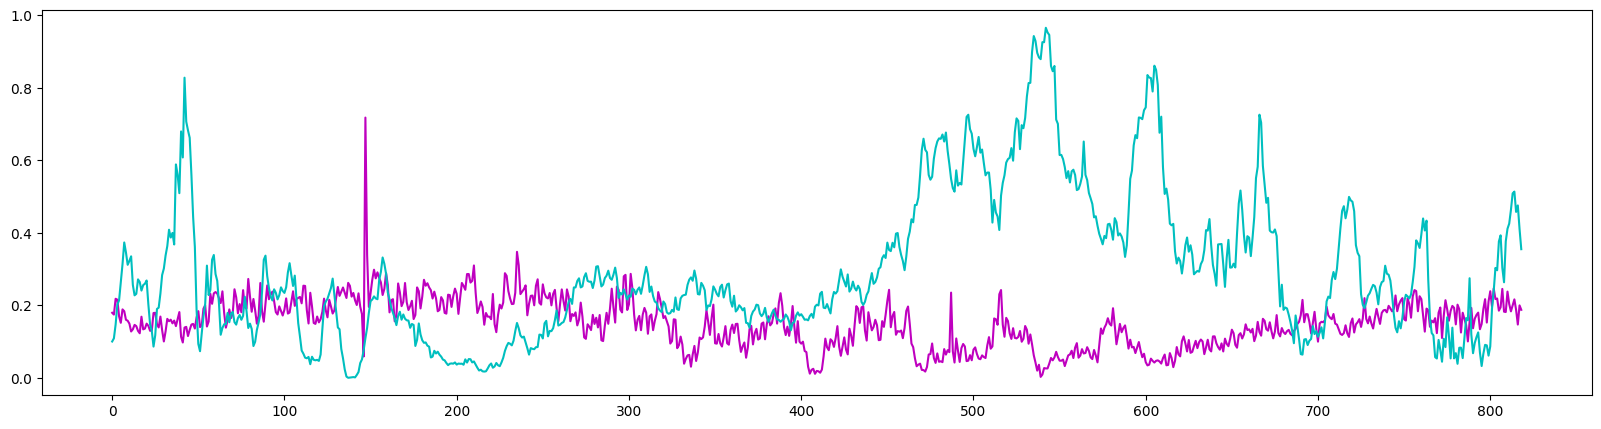

In [99]:
# plot the log log and line of best fit for one vag signal
fig, ax = plt.subplots(1,1, figsize=(20, 5))

ax.plot(n_list[1], color="m")
ax.plot(p_list[10], color="c")


In [87]:
# compute li over full signals

def compute_fft_mag_positive_f(data, fftpoints):
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2)
    return mag

def compute_loading_intensity(s, fft_points, fs, high_cut_off):
    LI = 0
    fc = high_cut_off
    kc = int((fft_points/fs)* fc) + 1

    magnitudes = compute_fft_mag_positive_f(s, fft_points)

    f = []
    for i in range(0, int(fft_points/2)+1):
        f.append((fs*i)/fft_points)

    for k in range(0, kc):
        LI = LI + (magnitudes[k] * f[k])

    return LI

n_li = []
n_li_ext_flex = []
p_li = []
p_li_ext_flex = []

for i, n in enumerate(n_res):
    li = compute_loading_intensity(n, len(n), fs, 1000) # high cutoff is nyquist
    n_li.append(li)
    n_li_ext = compute_loading_intensity(n_ext_flex[i][0], len(n_ext_flex[i][0]), fs, 1000)
    n_li_flx = compute_loading_intensity(n_ext_flex[i][1], len(n_ext_flex[i][1]), fs, 1000)
    n_li_ext_flex.append([n_li_ext, n_li_flx])

    if(i < len(p_res)):
        li = compute_loading_intensity(p_res[i], len(p_res[i]), fs, 1000) # high cutoff is nyquist
        p_li.append(li)
        p_li_ext = compute_loading_intensity(p_ext_flex[i][0], len(p_ext_flex[i][0]), fs, 1000)
        p_li_flx = compute_loading_intensity(p_ext_flex[i][1], len(p_ext_flex[i][1]), fs, 1000)
        p_li_ext_flex.append([p_li_ext, p_li_flx])

print(len(n_li_ext_flex), len(p_li_ext_flex))

print(f"LI normal: {float(np.mean(n_li))} +/- {round(np.std(n_li),4)}")
print(f"LI pathol: {np.mean(p_li)} +/- {round(np.std(p_li),4)}")

51 38
LI normal: 715.6450615917975 +/- 414.505
LI pathol: 675.0286693379126 +/- 385.4087


In [88]:
# turn the computed features into a dataframe

df = pd.DataFrame()

# state
n_state = np.ones(len(n_res),dtype=int)
p_state = np.zeros(len(p_res), dtype=int)
state = np.concatenate((n_state, p_state))

# FD
fd = np.concatenate((n_fd, p_fd))
n_fd_ext_flx = np.array(n_ext_flex_fd)
p_fd_ext_flx = np.array(p_ext_flex_fd)
n_fd_ext = n_fd_ext_flx[:, 0]
n_fd_flx = n_fd_ext_flx[:, 1]
p_fd_ext = p_fd_ext_flx[:, 0]
p_fd_flx = p_fd_ext_flx[:, 1]

fd_ext = np.concatenate((n_fd_ext, p_fd_ext))
fd_flx = np.concatenate((n_fd_flx, p_fd_flx))


# VMS
#n_mean_sqr = [] n_mean_sqr_ext_flex = [] p_mean_sqr = [] p_mean_sqr_ext_flex = []
vms = np.concatenate((n_mean_sqr, p_mean_sqr))
n_vms1 = np.array(n_mean_sqr_ext_flex)
p_vms1 = np.array(p_mean_sqr_ext_flex)
n_vms_ext = n_vms1[:, 0]
n_vms_flx = n_vms1[:, 1]
p_vms_ext = p_vms1[:, 0]
p_vms_flx = p_vms1[:, 1]

vms_ext = np.concatenate((n_vms_ext, p_vms_ext))
vms_flx = np.concatenate((n_vms_flx, p_vms_flx))

# LI
#n_li = [] n_li_ext_flex = [] p_li = [] p_li_ext_flex = []

li = np.concatenate((n_li, p_li))
n_li1 = np.array(n_li_ext_flex)
p_li1 = np.array(p_li_ext_flex)
print(len(n_li1))
n_li_ext = n_li1[:, 0]
n_li_flx = n_li1[:, 1]
p_li_ext = p_li1[:, 0]
p_li_flx = p_li1[:, 1]

li_ext = np.concatenate((n_li_ext, p_li_ext))
li_flx = np.concatenate((n_li_flx, p_li_flx))

df["STATE"] = state
df['FD'] = fd
df['FD_EXT'] = fd_ext
df['FD_FLX'] = fd_flx
df['VMS'] = vms
df['VMS_EXT'] = vms_ext
df['VMS_FLX'] = vms_flx
df['LI'] = li
df['LI_EXT'] = li_ext
df['LI_FLX'] = li_flx

print(df.head())


51
   STATE        FD    FD_EXT    FD_FLX       VMS   VMS_EXT   VMS_FLX  \
0      1  1.466570  1.775843  1.820782  0.025042  0.019168  0.029947   
1      1  1.766607  1.627739  1.922575  0.004414  0.003966  0.003024   
2      1  1.744344  1.869978  2.031547  0.003247  0.001370  0.004936   
3      1  2.287178  2.038849  2.328853  0.000181  0.000233  0.000093   
4      1  1.343740  1.526733  1.595508  0.010186  0.006659  0.003177   

           LI      LI_EXT      LI_FLX  
0  889.089284  614.701096  674.587386  
1  631.959945  454.240634  460.176026  
2  404.492380  217.192115  337.943733  
3  261.686751  252.636066   63.201615  
4  268.935033  199.078012  181.254098  


In [89]:
# write df to csv in features directory

In [90]:
directory = 'features'
file_name = 'vag_features.csv'
file_path = os.path.join(directory, file_name)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Write the DataFrame to a CSV file
df.to_csv(file_path, index=False)  # Set index=False to avoid writing row indices